In [1]:
# Useful libs
# Importing modules
import pandas as pd
import re
from sklearn import model_selection, naive_bayes, svm
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('Yelp.csv', error_bad_lines=False, engine='python')


# Load the regular expression library
data['numLabel'] = data['label'].apply(lambda x: 0 if x == 'price' else 1 if x == 'service' else 2 if x == 'food' else 3 if x == 'ambience' else 4)
data

,review,label,numLabel
0,"""Great place to hang out after work: the price...",price,0
1,"""Went here with visiting family members and wa...",price,0
2,"""One of the few good things that I have experi...",food,2
3,"""Alhambra location has a drive thru! But it's ...",service,1
4,"""Open during the quarantine with social distan...",service,1
5,"""Favorite Shawarma place in San Diego. Covid ...",food,2
6,"""The five-star food is only enhanced by the si...",food,2
7,"""Visited during the Covid Pandemic. You have t...",service,1
8,"""This place is cheap and yummy. My friends' mo...",service,1
9,"""During the pandemic, a good boba is all I nee...",food,2


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['numLabel'], test_size=0.8)
print(X_train)

14    "I'm pretty mad with you running chicks, it's ...
10    "Was craving some dim sum so got me a little s...
4     "Open during the quarantine with social distan...
12    "This is an awesome donut shop run by the frie...
Name: review, dtype: object


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)


##Tfidf_vect = TfidfVectorizer(max_features=5000)
##Tfidf_vect.fit(Corpus['text_final'])
##Train_X_Tfidf = Tfidf_vect.transform(Train_X)
##Test_X_Tfidf = Tfidf_vect.transform(Test_X)
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)
##SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
##SVM.fit(Train_X_Tfidf,Train_Y)# predict the labels on validation dataset
##predictions_SVM = SVM.predict(Test_X_Tfidf)# Use accuracy_score function to get the accuracy
##print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

testing_predictions = []
for i in range(len(X_test)):
    if predictions[i] == 1:
        testing_predictions.append('service')
    elif predictions[i] == 2:
        testing_predictions.append('food')
    elif predictions[i] == 3:
        testing_predictions.append('ambience')
    elif predictions[i] == 4:
        testing_predictions.append('none')
    else:
        testing_predictions.append('price')
        
check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'review':list(X_test)})
check_df.replace(to_replace=0, value='price', inplace=True)
check_df.replace(to_replace=1, value='service', inplace=True)
check_df.replace(to_replace=2, value='food', inplace=True)
check_df.replace(to_replace=3, value='ambience', inplace=True)
check_df.replace(to_replace=4, value='none', inplace=True)
check_df

,actual_label,prediction,review
0,food,service,"""One of the few good things that I have experi..."
1,food,service,"""These are seriously the best cookies that I'v..."
2,none,service,"""I happened to be passing by. Seems like a coo..."
3,food,service,"""This boba shop is one of my favorite out of t..."
4,food,none,"""The five-star food is only enhanced by the si..."
5,food,service,"""During the pandemic, a good boba is all I nee..."
6,service,service,"""This place is cheap and yummy. My friends' mo..."
7,food,service,"""Holy cow. Second week in a row to get these d..."
8,food,service,"""My mom and I found his place while shopping a..."
9,service,service,"""Alhambra location has a drive thru! But it's ..."


Accuracy score:  0.21052631578947367
Precision score:  0.21052631578947367
Recall score:  0.21052631578947367


Text(91.68, 0.5, 'predicted label')

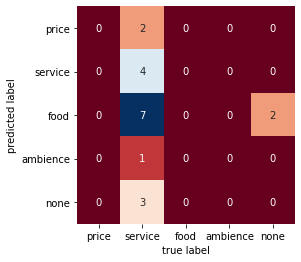

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions, average='micro'))
print('Recall score: ', recall_score(y_test, predictions, average='micro'))


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['price', 'service', 'food', 'ambience', 'none'], yticklabels=['price', 'service', 'food', 'ambience', 'none'])
plt.xlabel('true label')
plt.ylabel('predicted label')